# Iris

In [37]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
from sklearn.datasets import load_iris

## Data
Data is a famous iris dataset (loaded via sklearn module). Dataset has been divided into two parts - training (70%) and testing (30%).

In [2]:
torch.manual_seed(1)
np.random.seed(1)

iris = load_iris()
iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['species'])

iris.loc[:, iris.columns!='species'].describe().loc[['mean', 'std', 'min', '50%', 'max']]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
50%,5.800000,3.000000,4.350000,1.300000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
train_sample_size = int(150*0.7)

order = np.arange(150)
np.random.shuffle(order)

train_df = iris.iloc[order[:train_sample_size]]
test_df = iris.iloc[order[train_sample_size:]]

In [4]:
x_train = torch.from_numpy(train_df.loc[:, train_df.columns!='species'].to_numpy()).float()
y_train = torch.from_numpy(train_df['species'].to_numpy()).float()

x_test = torch.from_numpy(test_df.loc[:, train_df.columns!='species'].to_numpy()).float()
y_test = torch.from_numpy(test_df['species'].to_numpy()).float()

## Net
### Structure

In [5]:
def def_net(layers, activation="ReLU", lr=0.05, seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    modules = []
    
    if activation=="ReLU":
        func = torch.nn.ReLU()
    elif activation=="Sigmoid":
        func = torch.nn.Sigmoid()
    else:
        raise Exception("Wrong activation function.")
    
    for i in range(len(layers)-2):
        modules.append(torch.nn.Linear(layers[i], layers[i+1]))
        modules.append(func)
    modules.append(torch.nn.Linear(layers[-2], layers[-1]))
    modules.append(torch.nn.Softmax())
    
    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.normal_(m.weight, std=0.05)
            torch.nn.init.normal_(m.bias, std=0.05)
    
    global net, learning_rate, activation_func, loss, optimizer, neurons, net_seed
    net = torch.nn.Sequential(*modules)
    neurons = layers
    learning_rate = lr
    activation_func = activation
    net_seed = seed
    
    loss = torch.nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    net.apply(init_weights)

### Learning process

In [8]:
def learn(n_iter=128, b_size=8):
    global num_iter, batch_size, losses, train_errors, test_errors
    
    num_iter = n_iter
    batch_size = b_size

    losses = []
    train_errors = []
    test_errors = []

    for epoch in tqdm.tqdm(range(num_iter)):
        losses_iter = []
        train_errors_iter = []
        test_errors_iter = []

        y_hat = net(x_test)
        test_errors += [(y_test != y_hat.argmax(1)).float().mean().item()]

        y_hat = net(x_train)
        train_errors += [(y_train != y_hat.argmax(1)).float().mean().item()]

        for batch in range(train_sample_size//batch_size):
            x_batch = x_train[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size]

            y_hat = net(x_batch)
            l = loss(y_hat, y_batch.type(torch.LongTensor))
            optimizer.zero_grad()
            l.mean().backward()
            losses_iter += [l.mean().item()]
            optimizer.step()

        losses += [np.mean(losses_iter)]

## Results

In [89]:
def_net(layers=[4, 4, 3, 3], activation="ReLU", lr=0.05, seed=0)
learn()

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]C:\Users\Wodo\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 168.87it/s]


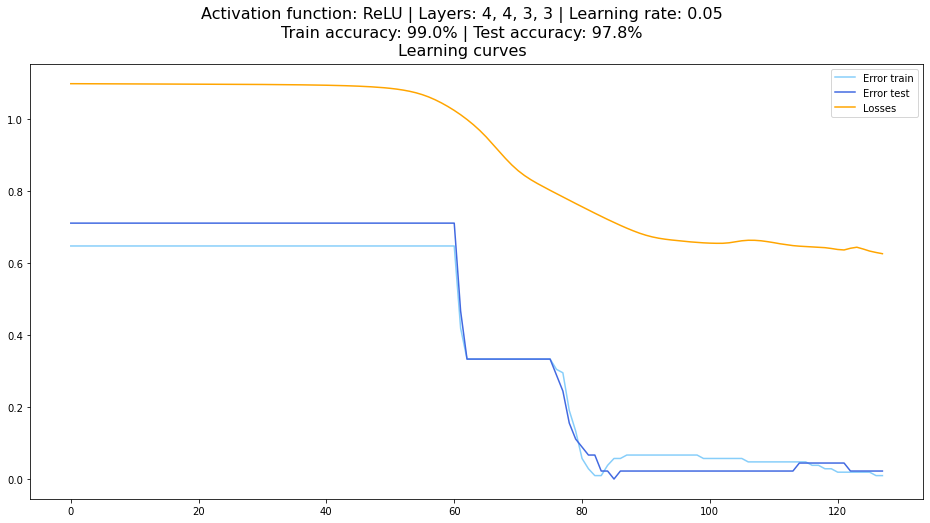

In [90]:
fig = plt.figure(figsize=(16, 8))
# ttime = 'Learning results after {num_iter:3} epochs'
tdesc = f'Activation function: {activation_func} | Layers: {str(neurons)[1:-1]} | Learning rate: {learning_rate:1.3}'
tstat = f'\nTrain accuracy: {1-train_errors[-1]:2.1%} | Test accuracy: {1-test_errors[-1]:2.1%}'
fig.suptitle(tdesc+tstat+"\nLearning curves",
             fontsize=16
            )
plt.plot(range(num_iter), train_errors, color='lightskyblue')
plt.plot(range(num_iter), test_errors, color='royalblue')
plt.plot(range(num_iter), losses, color='orange')
plt.legend(["Error train", "Error test", "Losses"])

# plt.savefig(f'results/iris/{activation_func + str(neurons)[1:-1:3] + "lr" + str(learning_rate)[2:]}.png')
plt.show()

## Nets comparison
### Data generation
Code below is used to generate some examples of nets to further comparison.

In [10]:
results = pd.DataFrame({'activation':[],
                        'layers':[],
                        'learning_rate':[],
                        'seed':[],
                        'epochs':[],
                        'training_accuracy':[],
                        'test_accuracy':[]})

for af in ['ReLU', 'Sigmoid']:
    for l in [[4, 3], [4, 2, 3], [4, 3, 3], [4, 4, 3], [4, 4, 3, 3]]:
        for lr in [0.5, 0.1, 0.05, 0.01]:
            for s in range(10):
                def_net(layers=l, activation=af, lr=lr, seed=s)
                learn()
                new_result = {'activation':activation_func,
                              'layers':str(neurons)[1:-1],
                              'learning_rate':learning_rate,
                              'seed':net_seed,
                              'epochs':num_iter,
                              'training_accuracy':1-train_errors[-1],
                              'test_accuracy':1-test_errors[-1]}
                results = results.append(new_result, ignore_index=True)
                
results.to_csv('results/iris/iris_results.csv')

### Parameters comparison

In [51]:
results = pd.read_csv('results/iris/iris_results.csv', index_col=0)

test = results.loc[:, results.columns!='training_accuracy']
test = test.rename(columns={'test_accuracy':'accuracy'})
test['set'] = 'testing'
train = results.loc[:, results.columns!='test_accuracy']
train = train.rename(columns={'training_accuracy':'accuracy'})
train['set'] = 'training'

results_stacked = test.append(train)

#### Net architecture
In general `ReLU` function seems to perform much better than `Sigmoid` on both sets. Number of layers and neurons in each layer abviously affects classification accuracy. Nets with (4,2,3), (4,3,3) and (4,4,3) neurons in each layer respectively have similar results. The simplest net with only two layers (simple linear model) performs the best and the most complicated net with layers (4, 4, 3, 3) has the worst results.

Text(0.5, 1.0, 'Nets performance comparizon on testing set')

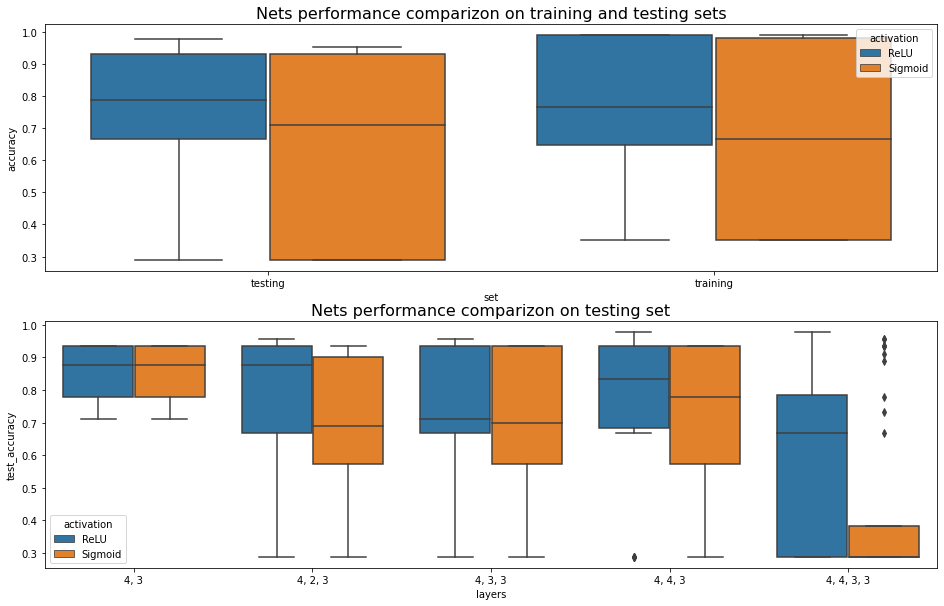

In [63]:
fig, ax = plt.subplots(2,1, figsize=(16, 10))
sns.boxplot(x='set', y='accuracy', hue='activation', data=results_stacked, ax=ax[0])
ax[0].set_title('Nets performance comparizon on training and testing sets', fontsize=16)
sns.boxplot(x='layers', y='test_accuracy', hue='activation', data=results, ax=ax[1])
ax[1].set_title('Nets performance comparizon on testing set', fontsize=16)

#### Learning rate
Learning rate also has a big impact on nets learning. In thos sitauation it is clear that value of 0.01 gives the worst results and value 0.1 is safe choice regardless of activation function.

Text(0.5, 0.98, 'Learning rate impact on nets performance')

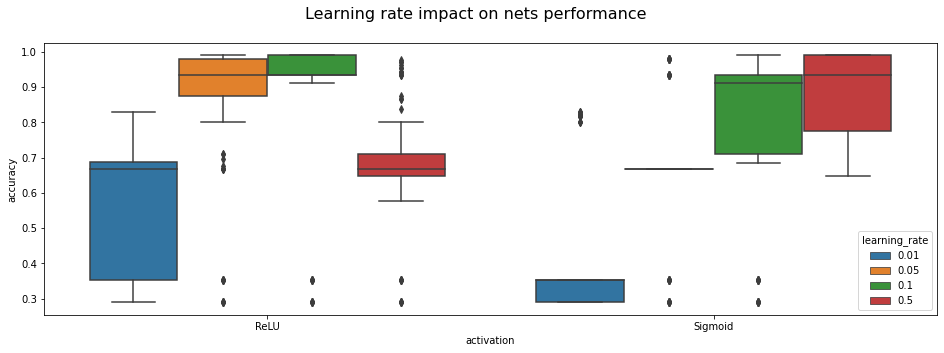

In [82]:
fig = plt.figure(figsize=(16, 5))
sns.boxplot(x='activation', y='accuracy', hue='learning_rate', data=results_stacked)
fig.suptitle('Learning rate impact on nets performance', fontsize=16)

#### Best performance
Despite the fact that in general simpler nets are doing better in this example, those more complicated have potential to reach better accuracy.

In [88]:
results.sort_values(by=['test_accuracy', 'training_accuracy'], ascending=False).head(10)

,activation,layers,learning_rate,seed,epochs,training_accuracy,test_accuracy
180,ReLU,"4, 4, 3, 3",0.05,0.0,128.0,0.990476,0.977778
173,ReLU,"4, 4, 3, 3",0.10,3.0,128.0,0.980952,0.977778
174,ReLU,"4, 4, 3, 3",0.10,4.0,128.0,0.980952,0.977778
175,ReLU,"4, 4, 3, 3",0.10,5.0,128.0,0.980952,0.977778
128,ReLU,"4, 4, 3",0.50,8.0,128.0,0.942857,0.977778
61,ReLU,"4, 2, 3",0.05,1.0,128.0,0.990476,0.955556
66,ReLU,"4, 2, 3",0.05,6.0,128.0,0.990476,0.955556
102,ReLU,"4, 3, 3",0.05,2.0,128.0,0.990476,0.955556
107,ReLU,"4, 3, 3",0.05,7.0,128.0,0.990476,0.955556
135,ReLU,"4, 4, 3",0.10,5.0,128.0,0.990476,0.955556


#### Conclusion
All net has been learned for only 128 epochs. It is reflected in their performances. Nets with simpler architecure (less layers, less neurons) generally behave better because they can learn faster. Nets learned with very small learning rate value have worse performance becase smaller learning rate usually means slower learning. Best accuracy is still achived with more complicated nets becasue they have potential to develop more complicated behaviours.